# Full data for linear probing CLIP on EuroSAT

In [2]:
import os
import numpy as np
import torch
import clip
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Define EuroSAT class names and descriptions
eu_sat_classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
                  'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
descriptions = ['This is a satellite image of annual crop',
                'This is a satellite image of forest',
                'This is a satellite image of herbaceous vegetation',
                'This is a satellite image of highway',
                'This is a satellite image of industrial',
                'This is a satellite image of pasture',
                'This is a satellite image of permanent crop',
                'This is a satellite image of residential',
                'This is a satellite image of river',
                'This is a satellite image of sea lake']
text_tokens = clip.tokenize(descriptions).to(device)

100%|███████████████████████████████████████| 338M/338M [02:19<00:00, 2.54MiB/s]


## Zero shot baseline

In [4]:
eu_sat_dir = '/Data/CV_Proj/data/'

In [5]:
# Load and preprocess images from the EuroSAT dataset
batch_size = 16
all_predictions = []
all_labels = []

# Process images in batches to reduce memory requirements
for cls_index, cls in enumerate(eu_sat_classes):
    cls_dir = os.path.join(eu_sat_dir, cls.replace(' ', '_'))
    filenames = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    num_batches = int(np.ceil(len(filenames) / batch_size))
    
    for batch_idx in tqdm(range(num_batches), desc=f"Processing {cls}", leave=False):
        batch_files = filenames[batch_idx * batch_size:(batch_idx + 1) * batch_size]
        batch_images = []
        batch_labels = []
        
        # Load and preprocess images for the current batch
        for filename in batch_files:
            image_path = os.path.join(cls_dir, filename)
            image = Image.open(image_path).convert("RGB")
            batch_images.append(preprocess(image).unsqueeze(0).to(device))
            batch_labels.append(cls_index)
        
        # Convert batch images to tensor and process with CLIP
        batch_images = torch.cat(batch_images)
        with torch.no_grad():
            text_features = model.encode_text(text_tokens).float()
            text_features /= text_features.norm(dim=-1, keepdim=True)
            batch_features = model.encode_image(batch_images).float()
            batch_features /= batch_features.norm(dim=-1, keepdim=True)
            batch_similarities = (batch_features @ text_features.T).softmax(dim=-1)
            batch_predictions = batch_similarities.argmax(dim=1).cpu().numpy()
        
        # Collect predictions and labels
        all_predictions.extend(batch_predictions)
        all_labels.extend(batch_labels)

In [6]:
# Convert collected labels and predictions to numpy arrays for evaluation
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Evaluation
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=eu_sat_classes))

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.44      0.61      0.51      3000
              Forest       0.39      0.36      0.37      3000
HerbaceousVegetation       0.50      0.00      0.00      3000
             Highway       0.35      0.64      0.45      2500
          Industrial       0.54      0.72      0.62      2500
             Pasture       0.40      0.57      0.47      2000
       PermanentCrop       0.34      0.21      0.26      2500
         Residential       0.72      0.88      0.79      3000
               River       0.22      0.15      0.18      2500
             SeaLake       0.25      0.20      0.22      3000

            accuracy                           0.43     27000
           macro avg       0.42      0.44      0.39     27000
        weighted avg       0.42      0.43      0.39     27000



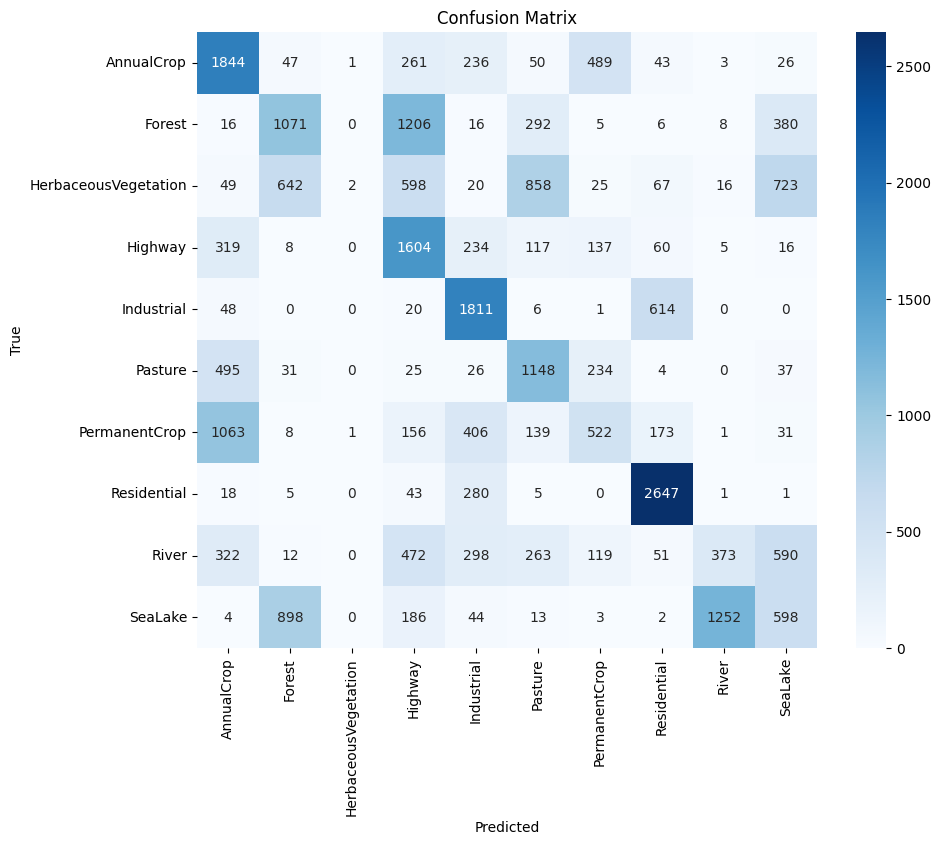

In [7]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=eu_sat_classes, yticklabels=eu_sat_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Full dataset linear probing

In [8]:
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

np.random.seed(2024)
torch.manual_seed(2024)

In [9]:
# Define a simple dataset class
class EuroSATDataset(Dataset):
    def __init__(self, file_paths, labels, preprocess):
        self.file_paths = file_paths
        self.labels = labels
        self.preprocess = preprocess

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        image = Image.open(file_path).convert("RGB")
        if self.preprocess:
            image = self.preprocess(image)
        return image, label

In [10]:
# Load the CLIP model and preprocessing
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Define EuroSAT class names
eu_sat_classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
                  'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
class_to_index = {cls: index for index, cls in enumerate(eu_sat_classes)}

# Load and split the EuroSAT dataset
all_files = []
all_labels = []

for cls in eu_sat_classes:
    cls_dir = os.path.join(eu_sat_dir, cls.replace(' ', '_'))
    filenames = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    all_files.extend(filenames)
    all_labels.extend([class_to_index[cls]] * len(filenames))

# Split into train, validation, and test sets
train_files, test_files, train_labels, test_labels = train_test_split(all_files, all_labels, test_size=0.2, random_state=2024)
train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.25, random_state=2024)

# Create dataset objects for each split
train_dataset = EuroSATDataset(train_files, train_labels, preprocess)
val_dataset = EuroSATDataset(val_files, val_labels, preprocess)
test_dataset = EuroSATDataset(test_files, test_labels, preprocess)

# Create data loaders for each split
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
# Define a simple classifier
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleClassifier, self).__init__()
        # Simple linear layer as classifier
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# Instantiate the classifier, optimizer, and loss function
input_dim = model.visual.output_dim  # Assuming using CLIP's image feature dimension
num_classes = len(eu_sat_classes)

classifier = SimpleClassifier(input_dim, num_classes).to(device)
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 100
validation_interval = 10  # Validate after every 10 epochs
save_interval = 20  # Save after every 20 epochs
early_stopping_patience = 10  # Number of epochs to wait for loss improvement
best_val_accuracy = 0  # Track best validation accuracy
no_improvement_epochs = 0  # Track epochs without improvement for early stopping
model_save_path = './models/best_model.pth'  # Path to save the best model

for epoch in range(num_epochs):
    classifier.train()  # Ensure the classifier is in training mode
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            image_features = model.encode_image(images).float()
            image_features /= image_features.norm(dim=-1, keepdim=True)
        outputs = classifier(image_features)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

    if (epoch + 1) % validation_interval == 0:
        classifier.eval()  # Set the classifier to evaluation mode
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Validation at Epoch {epoch+1}"):
                images, labels = images.to(device), labels.to(device)
                image_features = model.encode_image(images).float()
                image_features /= image_features.norm(dim=-1, keepdim=True)
                outputs = classifier(image_features)
                predicted = outputs.argmax(dim=1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_accuracy = 100 * val_correct / val_total
        print(f"Validation Accuracy at Epoch {epoch+1}: {val_accuracy:.2f}%")

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(classifier.state_dict(), model_save_path)
            print(f"Best model saved at Epoch {epoch+1}")
            no_improvement_epochs = 0  # Reset counter
        else:
            no_improvement_epochs += validation_interval
            if no_improvement_epochs >= early_stopping_patience:
                print(f"No improvement in validation accuracy for {early_stopping_patience} epochs, stopping training.")
                break  # Early stopping

        classifier.train()  # Set the classifier back to training mode

    # Save the model periodically
    if (epoch + 1) % save_interval == 0:
        periodic_save_path = f'./models/model_epoch_{epoch+1}.pth'
        torch.save(classifier.state_dict(), periodic_save_path)
        print(f"Model saved at Epoch {epoch+1} to {periodic_save_path}")

In [13]:
# model_path = model_save_path
model_path = "./models_cjn/best_model.pth"

In [15]:
# Evaluation with the best model
classifier.load_state_dict(torch.load(model_path))  # Load the best model
classifier.eval()  # Set the classifier to evaluation mode
all_predictions = []
all_labels = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        image_features = model.encode_image(images).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)
        outputs = classifier(image_features)
        predicted = outputs.argmax(dim=1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report and confusion matrix
print("Classification Report on Test Set:")
print(classification_report(all_labels, all_predictions, target_names=eu_sat_classes))

Testing:   0%|          | 0/338 [00:00<?, ?it/s]

Testing: 100%|██████████| 338/338 [00:09<00:00, 36.01it/s]

Classification Report on Test Set:
                      precision    recall  f1-score   support

          AnnualCrop       0.92      0.96      0.94       594
              Forest       0.96      0.98      0.97       587
HerbaceousVegetation       0.94      0.95      0.94       617
             Highway       0.92      0.90      0.91       479
          Industrial       0.98      0.98      0.98       526
             Pasture       0.94      0.92      0.93       406
       PermanentCrop       0.92      0.89      0.90       473
         Residential       0.99      0.99      0.99       606
               River       0.95      0.93      0.94       516
             SeaLake       0.99      0.99      0.99       596

            accuracy                           0.95      5400
           macro avg       0.95      0.95      0.95      5400
        weighted avg       0.95      0.95      0.95      5400



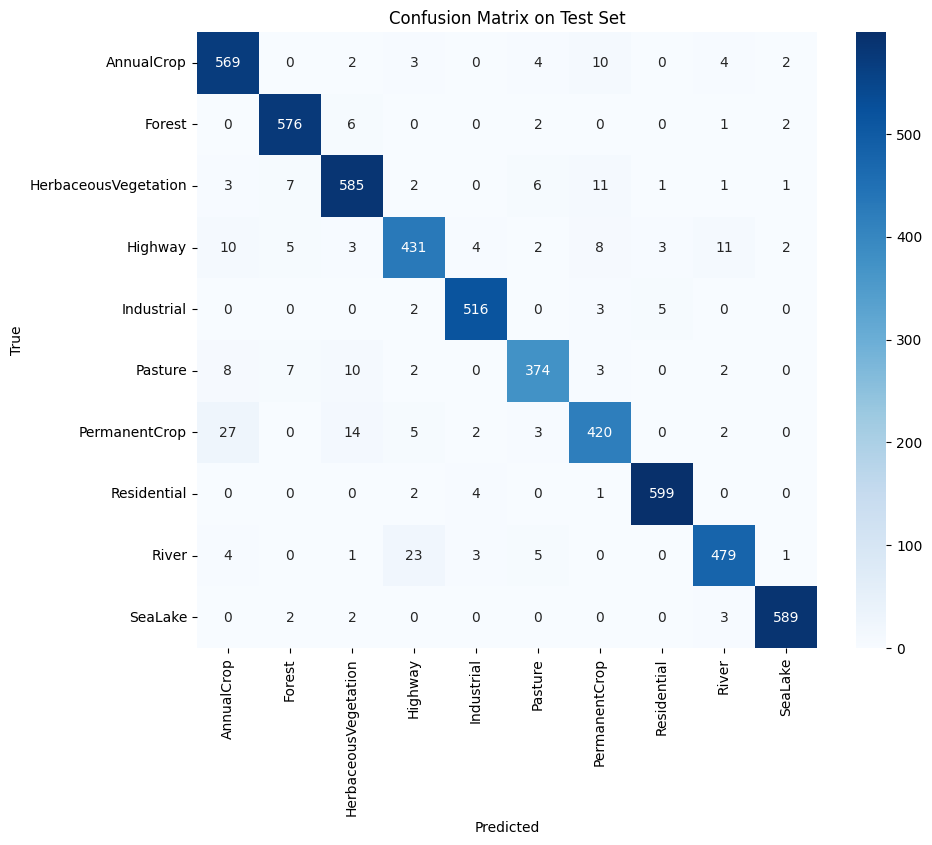

In [16]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=eu_sat_classes, yticklabels=eu_sat_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()